Note: [please first run `use_splatter_to_generate.ipynb` in R]  
use splatter-generated count data to build a kernel knn graph.  
then generate random coefiicient to filter the graph spectrum, obtaining a covariance matrix.  
use this covariance matrix to generate random normal signals.  
apply bernoulli or ZIP noises to the signals to get noisy signals.

In [1]:
import numpy as np
import magic
import pandas as pd
from utils import *

noiseless_data = pd.read_csv("truecounts.csv").set_index("Unnamed: 0")
noisy_data = pd.read_csv("dropouted.csv").set_index("Unnamed: 0")
# probabs = pd.read_csv("dropoutprob.csv").set_index("Unnamed: 0").to_numpy().T
cellmeans = pd.read_csv("cellmeans.csv").set_index("Unnamed: 0").to_numpy().T
y = noiseless_data.to_numpy().T
x = noisy_data.to_numpy().T

x_filt, c_id = filter_cells(x, return_ids=True)
x_filt, g_id = filter_genes(x_filt, return_ids=True)
x_filt, scales = lib_size_normalize(x_filt, to_size=10000, return_scale=True)

# y_filt = y[:, c_id][g_id, :]
# y_filt, scales = lib_size_normalize(y_filt, to_size=10000, return_scale=True)
# y_filt = log_transform(y_filt)

magic_op = magic.MAGIC()
# magic_op = magic_op.fit(y_filt.T)
magic_op = magic_op.fit(x_filt.T)
A = magic_op.graph.K.toarray()
d = A.sum(axis=0)
D = np.diag(d)
Dinvhf = np.diag(1/np.sqrt(d))
# L = Dinvhf @ (D - A) @ Dinvhf
L = Dinvhf @ A

np.random.seed(32)
t = 3
coef = np.random.rand(1)
coef = np.exp(coef - 1)
# coefs = np.random.rand(t)
# coefs = np.exp(coefs - 1)

# Ls = [np.identity(L.shape[0])]
# Ls = []
# # for i in range(1, t):
# for i in range(1, t+1):
#     Ls.append(L ** i)
# Ls = np.stack(Ls)

# filt = np.einsum("i,ijk->jk", coefs, Ls)
filt = coef * L ** t

Running MAGIC on 4867 cells and 1000 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.72 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.75 seconds.
  Calculating affinities...


/home/xs272/myconda/conda_envs/sc/lib/python3.10/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 2584 and 3839. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated affinities in 0.79 seconds.
Calculated graph and diffusion operator in 3.29 seconds.


In [2]:
n_genes, n_cells = x_filt.shape

In [3]:
simu_data = np.random.multivariate_normal(mean = np.zeros(n_cells), cov = filt, size=n_genes)

/tmp/ipykernel_26043/2404688448.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  simu_data = np.random.multivariate_normal(mean = np.zeros(n_cells), cov = filt, size=n_genes)


In [4]:
simu_data1 = np.exp(simu_data + 2)

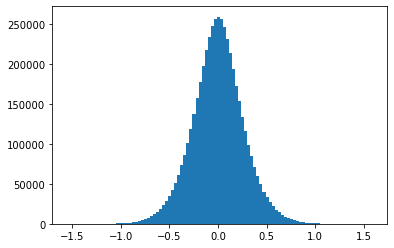

In [5]:
import matplotlib.pyplot as plt
plt.hist(simu_data.flatten(), 100)
plt.show()

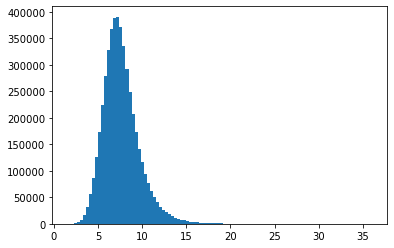

In [6]:
import matplotlib.pyplot as plt
plt.hist(simu_data1.flatten(), 100)
plt.show()

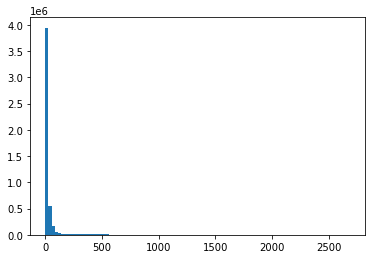

In [7]:
plt.hist(cellmeans.flatten(), 100)
plt.show()

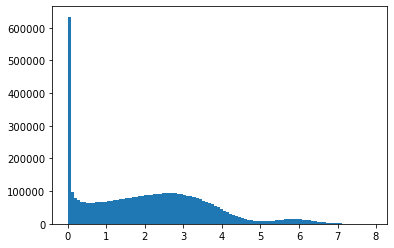

In [8]:
plt.hist(np.log1p(cellmeans).flatten(), 100)
plt.show()

In [9]:
pd.DataFrame(simu_data1).to_csv("simu_cellmeans.csv")

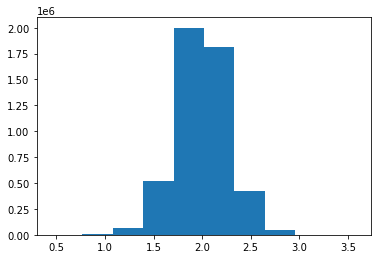

In [10]:
plt.hist((simu_data + 2).flatten())
plt.show()

## Bernoulli

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [18]:
dropout_probs = sigmoid((simu_data) * 4)

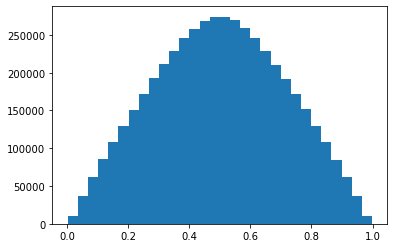

In [19]:
plt.hist(dropout_probs.flatten(), 30)
plt.show()

In [20]:
pd.DataFrame(dropout_probs).to_csv("simu_bern_dropout_prob.csv")

In [21]:
berns = np.random.binomial(1, dropout_probs)

In [22]:
simu_counts_bern = berns * simu_data1

In [23]:
pd.DataFrame(simu_counts_bern).to_csv("simu_bern_counts.csv")

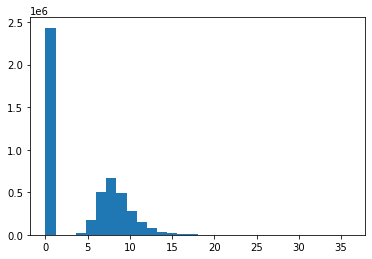

In [24]:
plt.hist(simu_counts_bern.flatten(), 30)
plt.show()

## Zero-inflated Poisson

In [25]:
beta = 1
simu_counts_pois = np.random.poisson(beta * simu_data1)

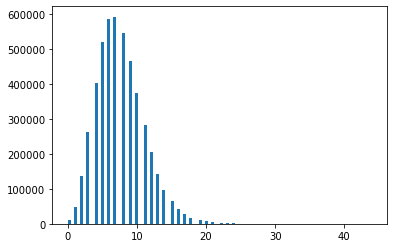

In [26]:
plt.hist(simu_counts_pois.flatten(), 100)
plt.show()

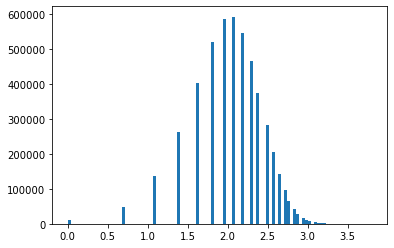

In [27]:
plt.hist(np.log1p(simu_counts_pois).flatten(), 100)
plt.show()

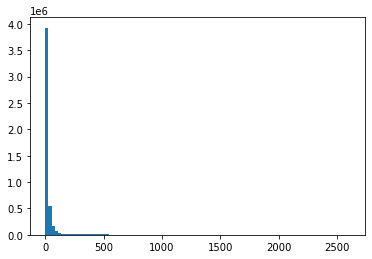

In [28]:
plt.hist(y.flatten(), 100)
plt.show()

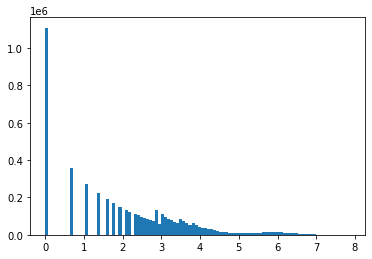

In [29]:
plt.hist(np.log1p(y).flatten(), 100)
plt.show()

In [30]:
pd.DataFrame(simu_counts_pois).to_csv("simu_pois_counts.csv")

In [49]:
dropout_probs_zip = sigmoid((np.log1p(simu_counts_pois) - 2) * 3)

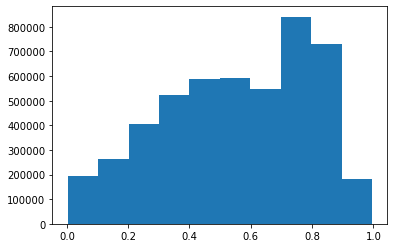

In [50]:
plt.hist(dropout_probs_zip.flatten())
plt.show()

In [51]:
pd.DataFrame(dropout_probs_zip).to_csv("simu_zip_dropout_prob.csv")

In [52]:
berns_zip = np.random.binomial(1, dropout_probs_zip)

In [53]:
simu_counts_zip = berns_zip * simu_counts_pois

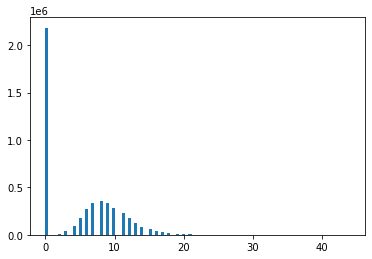

In [54]:
plt.hist(simu_counts_zip.flatten(), 100)
plt.show()

In [55]:
pd.DataFrame(simu_counts_zip).to_csv("simu_zip_counts.csv")

In [56]:
coef

array([0.86839315])